### This kernel was inspired by a tweet from Balaji Srinivasan - https://twitter.com/balajis/status/1207703228516904960

#### He wanted to know if DL can find correlations between a book's cover or in this case Movie Poster and it's associated Amazon rating/IMDB Score

### Imports

In [1]:
from fastai.vision import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
data = pd.read_csv('/kaggle/input/movie-genre-from-its-poster/MovieGenre.csv',engine='python')
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


## Number of Unique IMDB Scores (from 0-10*)
*Discounting Spinal Tap of course

In [2]:
len(data['IMDB Score'].unique())

85

### IMDB Score wise distribution in the dataset

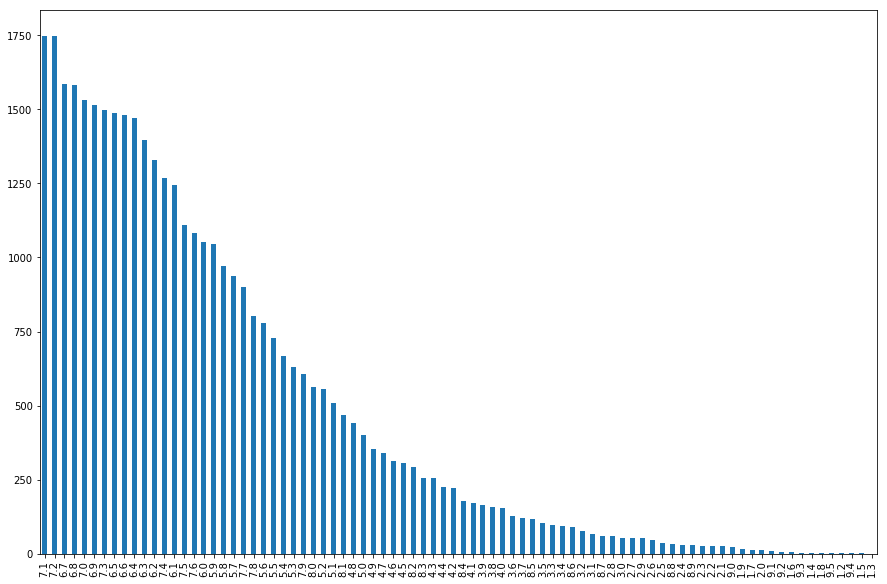

In [3]:
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(15,10)
data['IMDB Score'].value_counts().plot.bar(fig)

In [4]:
data.dropna(inplace=True)

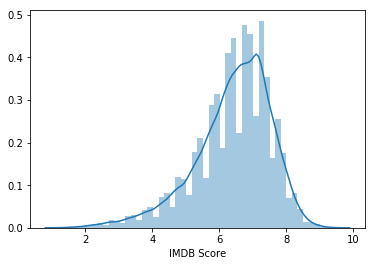

In [5]:
sns.distplot(data['IMDB Score'])

### Customized Image Dataset derived from the original Movie Posters dataset where filenames are named with their IMDB(Score and ID) and uses regex to parse their IMDB score for training labels

### Has close to 8.7k images - does increasing the dataset increase the performance of the model?

In [6]:
path_img = Path('/kaggle/input/movie-posters/poster_downloads/')
def get_float_labels(file_name):
    return float(re.search('\d.\d',str(file_name)).group())
def get_score_labels(file_name):
    return re.search('\d.\d',str(file_name)).group()

## Image Databunch from Fast.ai library
### One Image Databunch (data_reg) will act as the training data for a regression approach while the other (data_class) will consider it as a multi-label classification problem

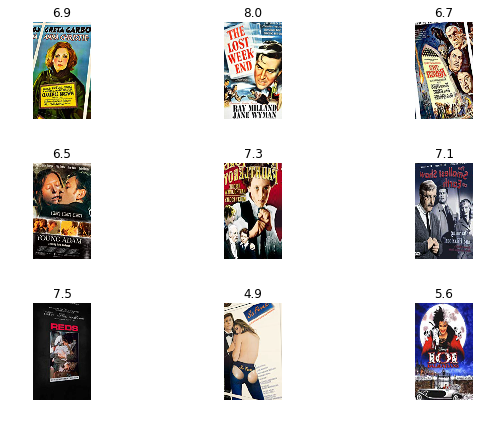

In [7]:
data_reg = (ImageList.from_folder(path_img)
 .split_by_rand_pct()
 .label_from_func(get_float_labels, label_cls=FloatList)
 .transform(get_transforms(), size=[300,180])
 .databunch()) 
data_reg.normalize(imagenet_stats)
data_reg.show_batch(rows=3, figsize=(9,6))

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
1.6
  if getattr(ds, 'warn', False): warn(ds.warn)


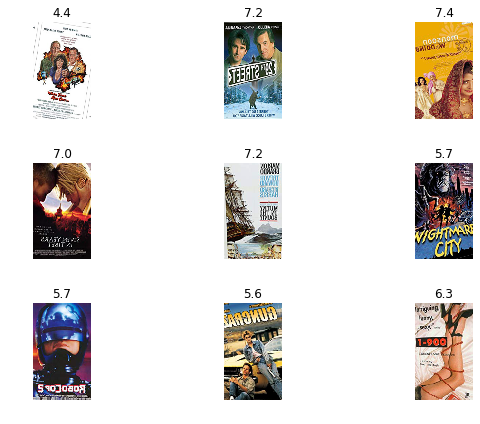

In [8]:
data_class = (ImageList.from_folder(path_img)
 .split_by_rand_pct()
 .label_from_func(get_score_labels)
 .transform(get_transforms(), size=[300,180])
 .databunch()) 
data_class.normalize(imagenet_stats)
data_class.show_batch(rows=3, figsize=(9,6))

## Custom Loss function - inspired from https://medium.com/@btahir/a-quick-guide-to-using-regression-with-image-data-in-fastai-117304c0af90

In [9]:
class L1LossFlat(nn.L1Loss):
    "Mean Absolute Error Loss"
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

## Initialize two trainers with ResNet 50 architecture but one for regression and the other for classification

In [10]:
learn_reg = create_cnn(data_reg, models.resnet50)
learn_reg.loss = L1LossFlat

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.5MB/s]


In [11]:
learn_class = create_cnn(data_class, models.resnet50,metrics=accuracy)

In [12]:
learn_reg.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,34.182388,16.664795,01:11
1,9.643997,2.175486,00:59
2,3.736730,1.449507,00:59
3,2.333658,1.238962,00:59
4,1.992599,1.129793,00:59


In [13]:
learn_class.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,5.667098,4.875936,0.038228,01:02
1,4.621750,4.151715,0.040655,01:00
2,3.910962,4.009036,0.043083,01:00
3,3.462031,3.957713,0.043689,01:01
4,3.160804,3.946679,0.046117,01:00


### Image Regression Results

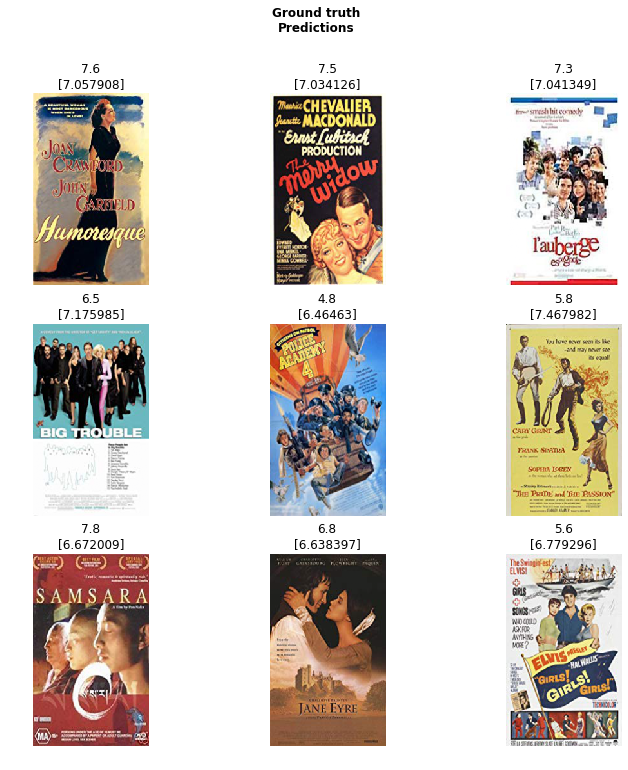

In [14]:
learn_reg.show_results(rows=3)

### Image Classification Results

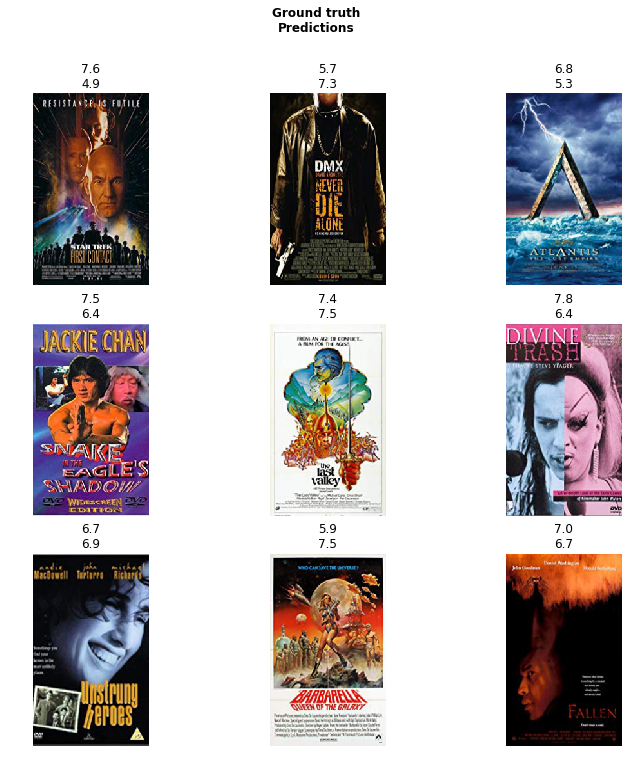

In [15]:
learn_class.show_results(rows=3)

### Scatterplot of Ground Truth and Predictions - Image Regression

In [16]:
preds,y,losses = learn_reg.get_preds(with_loss=True)
num_preds = [x[0] for x in np.array(preds)]
num_gt = [x for x in np.array(y)]
scat_data = pd.DataFrame(data={'Predictions':num_preds,'Ground_Truth':num_gt})

In [17]:
preds_cl,y_cl = learn_class.get_preds()
labels = np.argmax(preds_cl, 1)
preds_class = [float(data_class.classes[int(x)]) for x in labels]
y_class = [float(data_class.classes[int(x)]) for x in y_cl]
scat_data_cl = pd.DataFrame(data={'Predictions':preds_class,'Ground_Truth':y_class})

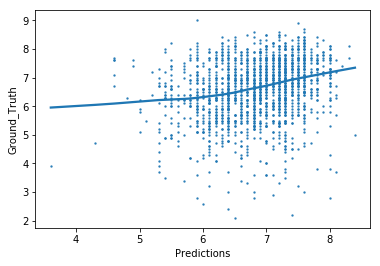

In [18]:
sns.regplot(x='Predictions',y='Ground_Truth',data = scat_data_cl,lowess=True,scatter_kws={'s':2})

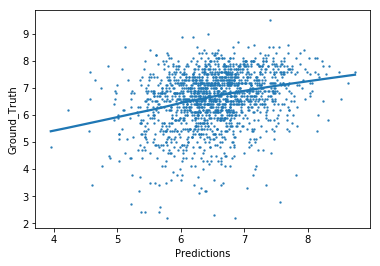

In [19]:
sns.regplot(x='Predictions',y='Ground_Truth',data = scat_data,lowess=True,scatter_kws={'s':2})

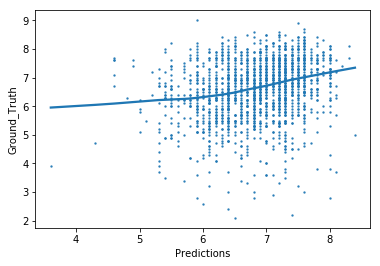

In [20]:
sns.regplot(x='Predictions',y='Ground_Truth',data = scat_data_cl,lowess=True,scatter_kws={'s':2})

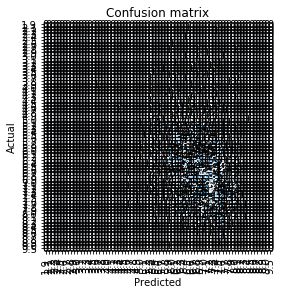

In [21]:
preds_class,y_class,losses_class = learn_class.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_class, preds_class, y_class, losses_class)
interp.plot_confusion_matrix()

### Some of the most confusing examples for the Image Classification Model

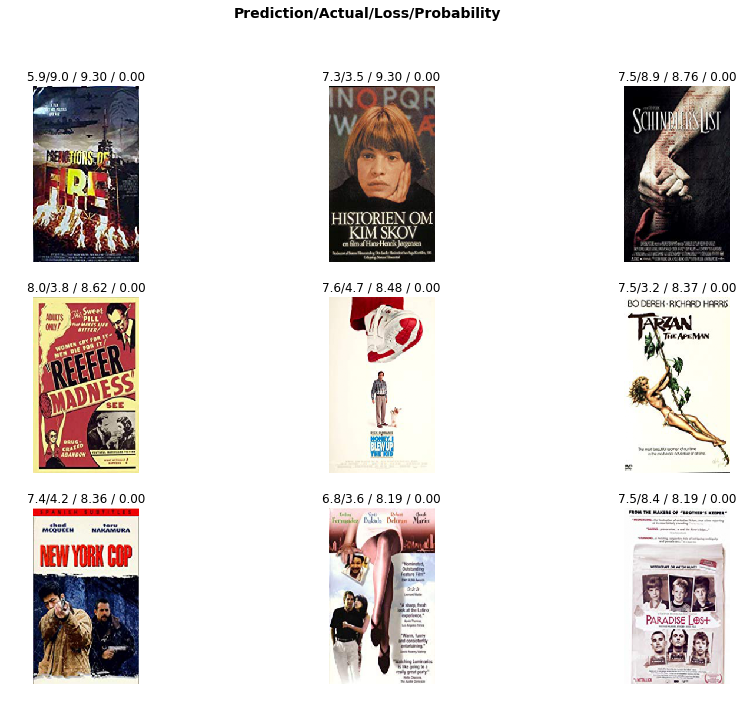

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

### Testing the model with BvS (IMDB rating - 6.5)
![Batman Vs Superman](https://m.media-amazon.com/images/M/MV5BYThjYzcyYzItNTVjNy00NDk0LTgwMWQtYjMwNmNlNWJhMzMyXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_QL50_SY1000_CR0,0,675,1000_AL_.jpg**)

In [23]:
learn_reg.export('/kaggle/output/')
learn_class.export('/kaggle/output/')
img1 = open_image('/kaggle/input/test-images/test1.jpg')
img2 = open_image('/kaggle/input/test-images/test2.jpg')

## Predictions of IR and IC models

In [24]:
print("Predicted IMDB Score of Image Regression Model is: ",learn_reg.predict(img1)[0])
print("Predicted IMDB Score of Image Classification Model is: ",learn_class.predict(img1)[0])

Predicted IMDB Score of Image Regression Model is:  [6.573227]
Predicted IMDB Score of Image Classification Model is:  7.0


### Similarly we test with one of 2019's top rated movie - Parasite (IMDB rating - 8.6)
![Parasite](https://m.media-amazon.com/images/M/MV5BYWZjMjk3ZTItODQ2ZC00NTY5LWE0ZDYtZTI3MjcwN2Q5NTVkXkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_QL50_SY1000_CR0,0,674,1000_AL_.jpg)

In [25]:
print("Predicted IMDB Score of Image Regression Model is: ",learn_reg.predict(img2)[0])
print("Predicted IMDB Score of Image Classification Model is: ",learn_class.predict(img2)[0])

Predicted IMDB Score of Image Regression Model is:  [7.15026]
Predicted IMDB Score of Image Classification Model is:  6.4


### In Conclusion, best not to judge a movie by it's poster? :)